# Face detection and recognition inference pipeline

The following example illustrates how to use the `facenet_pytorch` python package to perform face detection and recogition on an image dataset using an Inception Resnet V1 pretrained on the VGGFace2 dataset.

The following Pytorch methods are included:
* Datasets
* Dataloaders
* GPU/CPU processing

In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

#### Determine if an nvidia GPU is available

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


#### Define MTCNN module

Default params shown for illustration, but not needed. Note that, since MTCNN is a collection of neural nets and other code, the device must be passed in the following way to enable copying of objects when needed internally.

See `help(MTCNN)` for more details.

In [3]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device, keep_all = True
)

#### Define Inception Resnet V1 module

Set classify=True for pretrained classifier. For this example, we will use the model to output embeddings/CNN features. Note that for inference, it is important to set the model to `eval` mode.

See `help(InceptionResnetV1)` for more details.

In [4]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

#### Define a dataset and data loader

We add the `idx_to_class` attribute to the dataset to enable easy recoding of label indices to identity names later one.

In [6]:
from PIL import Image, ImageDraw
aligned_faces = []
picture_tracked = []
detected_faces = [] 
image_paths = ["../drama/drama_01","../drama/drama_02"] 
for p in image_paths:
    for img in os.listdir(p):
        im = Image.open(os.path.join(p, img))
        im = im.convert('RGB')
        boxes, _ = mtcnn.detect(im)
        aligned, prob= mtcnn(im, return_prob=True)
        if aligned is not None:
            for a in aligned: 
                aligned_faces.append(a)
        if boxes is None:
            continue
        frame_draw = im.copy()
        draw = ImageDraw.Draw(frame_draw)
        for box in boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
            face = frame_draw.crop(box)
            detected_faces.append(face)
        picture_tracked.append(frame_draw)

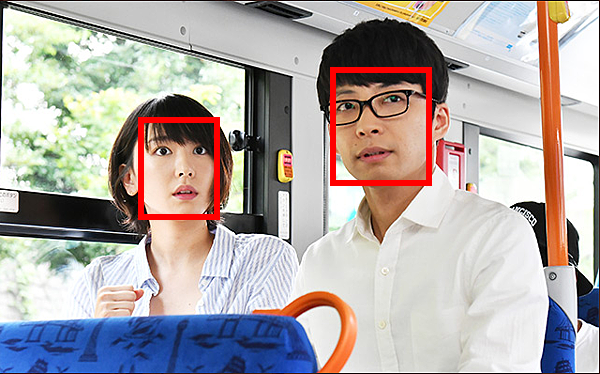

In [7]:
from IPython import display

d = display.display(picture_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(picture_tracked[i % len(picture_tracked)])
        i += 1
except KeyboardInterrupt:
    pass

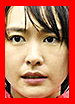

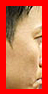

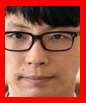

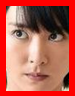

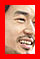

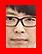

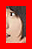

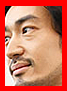

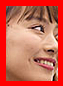

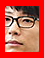

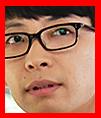

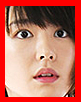

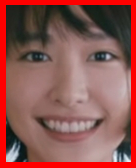

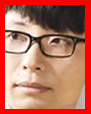

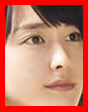

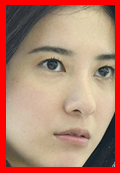

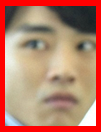

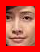

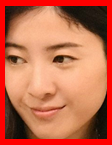

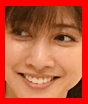

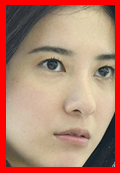

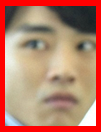

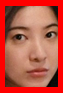

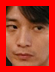

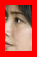

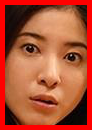

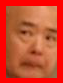

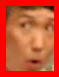

In [10]:
for face in detected_faces:
    display.display(face, display_id=True)

In [14]:
# names = ["新垣結衣", "配角1", "星野源", "新垣結衣2", "配角2",
#          "配角3", "星野源2", "星野源3", "新垣結衣3", "新垣結衣4",
#          "配角2-2", "星野源4", "新垣結衣5", "星野源5","新垣結衣6", "吉高由里子",
#          "配角4", "吉高由里子2","配角4","內田有紀","吉高由里子3","內田有紀2","吉高由里子4",
#          "向井理","吉高由里子5", "配角5", "配角6","內田有紀3"]


names = ["Aragaki_Yui", "co_star1", "Hoshino_Gen", "Aragaki_Yui2", "co_star2",
         "co_star3", "Hoshino_Gen2", "Hoshino_Gen3", "Aragaki_Yui3", "Aragaki_Yui4",
         "co_star2-2", "Hoshino_Gen4", "Aragaki_Yui5", "Hoshino_Gen5","Aragaki_Yui6", "Yuriko_Yoshitaka",
         "co_star4", "Yuriko_Yoshitaka2","co_star4","Yuki_Uchida","Yuriko_Yoshitaka3","Yuki_Uchida2","Yuriko_Yoshitaka4",
         "Mukai_Osamu","Yuriko_Yoshitaka5", "co_star5", "co_star6","Yuki_Uchida3"]

#### Calculate image embeddings

MTCNN will return images of faces all the same size, enabling easy batch processing with the Resnet recognition module. Here, since we only have a few images, we build a single batch and perform inference on it. 

For real datasets, code should be modified to control batch sizes being passed to the Resnet, particularly if being processed on a GPU. For repeated testing, it is best to separate face detection (using MTCNN) from embedding or classification (using InceptionResnetV1), as calculation of cropped faces or bounding boxes can then be performed a single time and detected faces saved for future use.

In [11]:
aligned = torch.stack(tuple(aligned_faces)).to(device)

embeddings = resnet(aligned).detach().cpu()
embeddings

tensor([[ 0.0039, -0.0133, -0.0193,  ...,  0.0053, -0.0106,  0.0948],
        [ 0.0587,  0.0370, -0.0230,  ..., -0.0130,  0.0542,  0.0270],
        [ 0.0298,  0.0072, -0.0549,  ..., -0.0665,  0.0125, -0.0271],
        ...,
        [-0.0157, -0.0210, -0.0355,  ..., -0.0167, -0.0607,  0.0480],
        [ 0.0755,  0.0061,  0.0737,  ..., -0.0660, -0.0589,  0.0326],
        [ 0.0806, -0.0204,  0.0039,  ..., -0.0047,  0.0597,  0.0253]])

In [12]:
embeddings.shape

torch.Size([28, 512])

#### Print distance matrix for classes

In [15]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
df = pd.DataFrame(dists, columns=names, index=names)
df 

,Aragaki_Yui,co_star1,Hoshino_Gen,Aragaki_Yui2,co_star2,co_star3,Hoshino_Gen2,Hoshino_Gen3,Aragaki_Yui3,Aragaki_Yui4,...,co_star4,Yuki_Uchida,Yuriko_Yoshitaka3,Yuki_Uchida2,Yuriko_Yoshitaka4,Mukai_Osamu,Yuriko_Yoshitaka5,co_star5,co_star6,Yuki_Uchida3
Aragaki_Yui,0.000000,1.343662,1.208726,0.815007,1.290794,1.216909,1.002213,1.250100,0.879350,1.241082,...,1.105719,0.986124,1.045298,1.255798,1.109386,1.179677,0.863250,0.930957,1.305175,1.390276
co_star1,1.343662,0.000000,1.175419,1.321910,1.204889,1.171320,1.397393,1.272980,1.273409,1.141824,...,1.400877,1.392173,1.443549,1.234461,1.409197,1.149682,1.394297,1.404097,1.260387,1.058240
Hoshino_Gen,1.208726,1.175419,0.000000,1.283399,1.201993,0.616557,1.144930,1.099098,1.230183,0.655812,...,1.300190,1.174783,1.249844,1.291325,1.222568,1.005991,1.292547,1.222410,1.254288,1.249173
Aragaki_Yui2,0.815007,1.321910,1.283399,0.000000,1.428876,1.230829,1.029692,1.406008,0.916996,1.278525,...,1.142945,0.986131,1.031043,1.147891,1.139858,1.302935,0.910368,1.013478,1.334812,1.408983
co_star2,1.290794,1.204889,1.201993,1.428876,0.000000,1.277836,1.309058,0.415992,1.256887,1.271863,...,1.277405,1.416802,1.460481,1.081919,1.393000,1.058141,1.431142,1.339005,1.112464,1.267785
co_star3,1.216909,1.171320,0.616557,1.230829,1.277836,0.000000,1.055003,1.182013,1.152548,0.594502,...,1.326613,1.180522,1.271425,1.228781,1.258141,1.027726,1.248413,1.232439,1.282139,1.300191
Hoshino_Gen2,1.002213,1.397393,1.144930,1.029692,1.309058,1.055003,0.000000,1.267258,1.023736,1.097014,...,1.077564,0.826202,1.075113,1.076906,1.021806,0.990179,0.977734,1.087050,1.413853,1.362061
Hoshino_Gen3,1.250100,1.272980,1.099098,1.406008,0.415992,1.182013,1.267258,0.000000,1.252075,1.187206,...,1.328877,1.413951,1.470162,1.026007,1.404775,1.010110,1.393233,1.345110,1.202012,1.281859
Aragaki_Yui3,0.879350,1.273409,1.230183,0.916996,1.256887,1.152548,1.023736,1.252075,0.000000,1.224495,...,1.142089,0.981378,1.084023,1.184031,1.149197,1.213096,0.981640,1.089724,1.289047,1.539228
Aragaki_Yui4,1.241082,1.141824,0.655812,1.278525,1.271863,0.594502,1.097014,1.187206,1.224495,0.000000,...,1.295897,1.229173,1.173940,1.191239,1.214382,0.930728,1.254270,1.146411,1.262709,1.171845


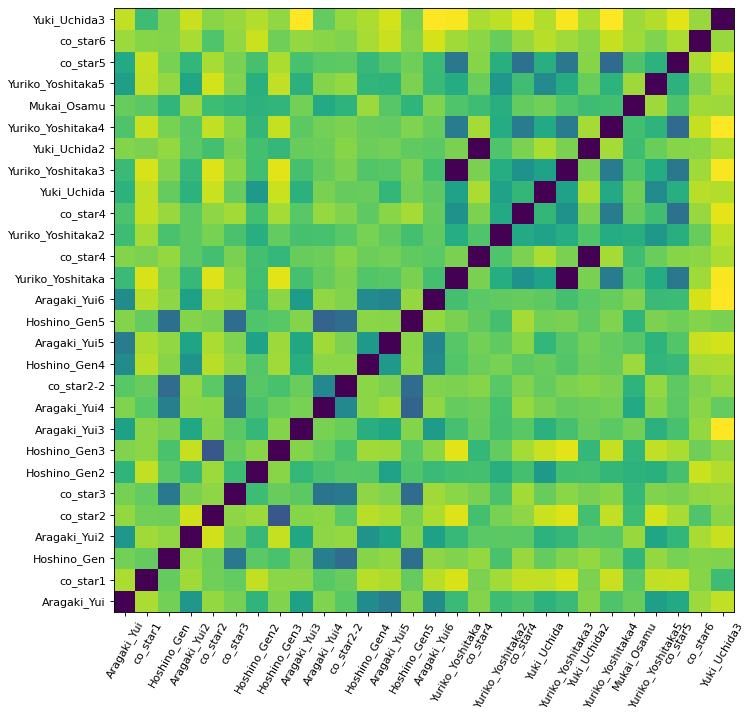

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.xticks(rotation = 60) 
plt.pcolor(df)

In [20]:
!pip install requests 
!pip install requests-aws4auth
!pip install Elasticsearch==7.12.1
!pip install urllib3

In [21]:
from elasticsearch import Elasticsearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth
import boto3

host = 'search-image-retrieval-bnppfgqwzoeu5dugmryflqaboa.us-west-2.es.amazonaws.com' # For example, my-test-domain.us-east-1.es.amazonaws.com
region = 'us-west-2' # e.g. us-west-1

service = 'es'
credentials = boto3.Session().get_credentials()



es = Elasticsearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = ('root','Peggy@@0218'),
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection
)

In [48]:
# es.indices.delete(index='faces', ignore=[400, 404])


{'acknowledged': True}

In [22]:
knn_index = {
    "settings": {
        "index.knn": True
    },
    "mappings": {
        "properties": {
            "face_vector": {
                "type": "knn_vector",
                "dimension": 512
            }
        }
    }
}

es.indices.create(index="faces",body=knn_index,ignore=400)

{'error': {'root_cause': [{'type': 'resource_already_exists_exception',
    'reason': 'index [faces/gaQjXgJYQZqeVz9e8pOnLg] already exists',
    'index_uuid': 'gaQjXgJYQZqeVz9e8pOnLg',
    'index': 'faces'}],
  'type': 'resource_already_exists_exception',
  'reason': 'index [faces/gaQjXgJYQZqeVz9e8pOnLg] already exists',
  'index_uuid': 'gaQjXgJYQZqeVz9e8pOnLg',
  'index': 'faces'},
 'status': 400}

In [23]:
def es_import(vector, celebid, id):
    es.index(index='faces',
             id=id, 
             body={"face_vector": vector, 
                   "celebid":celebid})
        
# es_import([0 for i in range(0, 256)], "q1")

In [24]:
for idx, (name, vector) in enumerate(zip(names, embeddings)): 
    es_import(vector.tolist(), name, idx)
    

In [25]:
def post(vector):
    res = es.search(index="faces",
                    body={
                        "size": 5,
                            "_source": {
                                "exclude": ["face_vector"]
                            },
                            "min_score": 0.3,
                            "query": {
                                "knn": {
                                    "face_vector": {
                                        "vector": vector,
                                        "k": 5
                                    }
                                }
                            }
                    })
    return res



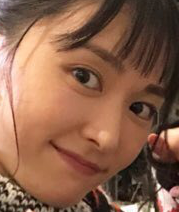

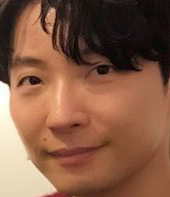

{'took': 989, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 20, 'relation': 'eq'}, 'max_score': 0.7305113, 'hits': [{'_index': 'faces', '_type': '_doc', '_id': '12', '_score': 0.7305113, '_source': {'celebid': 'Aragaki_Yui5'}}, {'_index': 'faces', '_type': '_doc', '_id': '14', '_score': 0.66304576, '_source': {'celebid': 'Aragaki_Yui6'}}, {'_index': 'faces', '_type': '_doc', '_id': '0', '_score': 0.609805, '_source': {'celebid': 'Aragaki_Yui'}}, {'_index': 'faces', '_type': '_doc', '_id': '11', '_score': 0.588347, '_source': {'celebid': 'Hoshino_Gen4'}}, {'_index': 'faces', '_type': '_doc', '_id': '8', '_score': 0.5807433, '_source': {'celebid': 'Aragaki_Yui3'}}]}}
{'took': 995, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 20, 'relation': 'eq'}, 'max_score': 0.67049056, 'hits': [{'_index': 'faces', '_type': '_doc', '_id': '2', '_score': 0.670490

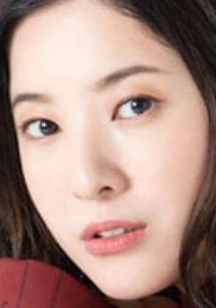

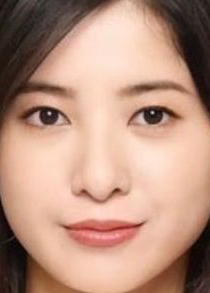

{'took': 608, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 20, 'relation': 'eq'}, 'max_score': 0.781139, 'hits': [{'_index': 'faces', '_type': '_doc', '_id': '25', '_score': 0.781139, '_source': {'celebid': 'co_star5'}}, {'_index': 'faces', '_type': '_doc', '_id': '20', '_score': 0.7377866, '_source': {'celebid': 'Yuriko_Yoshitaka3'}}, {'_index': 'faces', '_type': '_doc', '_id': '15', '_score': 0.7377863, '_source': {'celebid': 'Yuriko_Yoshitaka'}}, {'_index': 'faces', '_type': '_doc', '_id': '22', '_score': 0.6921639, '_source': {'celebid': 'Yuriko_Yoshitaka4'}}, {'_index': 'faces', '_type': '_doc', '_id': '18', '_score': 0.669471, '_source': {'celebid': 'co_star4'}}]}}
{'took': 8, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 20, 'relation': 'eq'}, 'max_score': 0.73732126, 'hits': [{'_index': 'faces', '_type': '_doc', '_id': '15', '_score': 0.

In [26]:
p="../drama/"
test_aligned = []
for img in ['test1.jpeg', 'test2.jpg']:
    im = Image.open(os.path.join(p, img))
    im = im.convert('RGB')
    boxes, _ = mtcnn.detect(im)
    aligned, prob= mtcnn(im, return_prob=True)
    for b in boxes: 
        display.display(im.crop(b), display_id=True)

    aligned = torch.stack(tuple(aligned)).to(device)
    embeddings = resnet(aligned).detach().cpu()
    for emb in embeddings:
        result = post(emb.tolist())
        print(result)
        